```markdown
# What is Pair Trading?

Pair trading, also known as statistical arbitrage or market-neutral trading, is a strategy that involves simultaneously buying and selling two related securities. This is done to profit from the relative performance of the two assets rather than the overall market direction. In pair trading, a "pair" is formed by selecting two stocks, A and B, with a historical price relationship.

## Logic Behind Pair Trading
The fundamental idea is based on the assumption that the two stocks in a pair have a historical relationship likely to continue. This relationship can be established through fundamental and technical analysis. When the relationship deviates, traders take positions expecting a reversion to the mean.

## Essential Statistical Concepts of Pair Trading

### Correlation:
Correlation measures the degree to which two stocks move in relation to each other. A correlation coefficient close to +1 indicates a strong positive correlation, -1 indicates a strong negative correlation, and 0 indicates no correlation.

### Cointegration:
Cointegration measures the long-term equilibrium relationship between two stocks. If two stocks are cointegrated, they tend to move together in the long run, even if they deviate in the short term. This stability is crucial for pair trading.

### Mean-Reversion:
Mean-reversion suggests that over time, the prices of the two stocks will tend to revert to their historical average. Traders exploit this tendency by taking positions when prices deviate significantly from the mean.

## Augmented Dickey-Fuller Test
The Augmented Dickey-Fuller (ADF) test is used to determine if a time series is stationary. Stationarity is crucial for mean-reverting strategies. If the ADF test indicates non-stationarity, differencing the time series may be necessary.

## Steps in Pair Trading

### Selecting Stocks for Pair Trading:
Example Pair: Stock A and Stock B

#### Correlation Analysis:
Calculate the correlation coefficient (ρ) between daily returns.
Example: ρ = 0.75 (indicating a strong positive correlation).

#### Cointegration Test:
Use the Engle-Granger test.
Example: The test statistic is significant, confirming cointegration.

### Defining Entry and Exit Points:
Example Spread Calculation:

#### Z-Score Calculation:
Calculate the spread between the prices of Stock A and Stock B.
Spread=Price of A−Price of B

Calculate the mean spread and standard deviation of the spread.

Z =(Spread−Mean Spread )/Standard Deviation of Spread

Example: If Z = -2, the spread is 2 standard deviations below the mean.

#### Setting Thresholds:
Define entry and exit Z-score thresholds.
Example: Enter when Z < -2, exit when Z > -1.

## Illustration

### Trade Execution:
Z-score reaches -2, indicating an entry point.

Execute a pair trade by buying Stock A and selling Stock B.

Z-score reaches -1, indicating an exit point.

Close the pair trade by selling Stock A and buying back Stock B.
```

https://github.com/JerBouma/AlgorithmicTrading/blob/master/Statistical%20Arbitrage/Pairs%20Trading%20Jupyter%20Notebook.ipynb

配對交易是一種股票交易策略，通常涉及同時買入和放空兩檔相關性高的股票，利用它們之間價格的擴散關係來獲取利潤。例如投資人同時買入看好的一檔股票並賣出另一檔不夠看好的股票，只要看好的股票漲幅大於不夠看好的股票，或是看好的股票跌幅小於不夠看好的股票，投資者就可以從收益中彌補損失而實現獲利。

世芯的基本面是資本額 7.23 億 3 月營收 25.5 億年成長 198%，創意的基本面是資本額 13.4 億 3 月營收 21.9 億年成長 46%，世芯資本額比創意小很多但是營收數字比卻比創意還大，加上成長率也大幅領先創意，因此創造了可以配對交易的環境，就是做多世芯同時放空創意。而凱基三多跟摩根大通為什麼不直接做多世芯就好了呢? 原因有 2 點，第 1 點是對於世芯目前已經大漲一段的股價，不確定未來會持續上漲，因此加上放空創意組成配對交易；第 2 點是這是避險基金下的單子，此避險基金的策略規範要規避市場的波動賺取穩定的收益。

# Statistical Arbitrage - Pairs Trading

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt
import yfinance as yf
from Cointegration import estimate_long_run_short_run_relationships, engle_granger_two_step_cointegration_test

In [71]:
market_data = pd.DataFrame()
stock_names = ['3661.TW', '3443.TW']
for i in stock_names:
    stock = yf.download(i, start='2020-01-01', end='2023-11-30')
    stock = stock[['Adj Close', 'Volume']]
    stock.rename(columns={'Adj Close': i[:4]+'.Price', 'Volume': i[:4]+'.Volume'}, inplace=True)
    market_data = pd.concat([market_data, stock], axis=1)

market_data
stock_names = ['3661', '3443']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


/var/folders/8f/5fqw1kqx0xz3b9pj_q9mf9gh0000gn/T/ipykernel_24029/405234900.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock.rename(columns={'Adj Close': i[:4]+'.Price', 'Volume': i[:4]+'.Volume'}, inplace=True)
/var/folders/8f/5fqw1kqx0xz3b9pj_q9mf9gh0000gn/T/ipykernel_24029/405234900.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock.rename(columns={'Adj Close': i[:4]+'.Price', 'Volume': i[:4]+'.Volume'}, inplace=True)


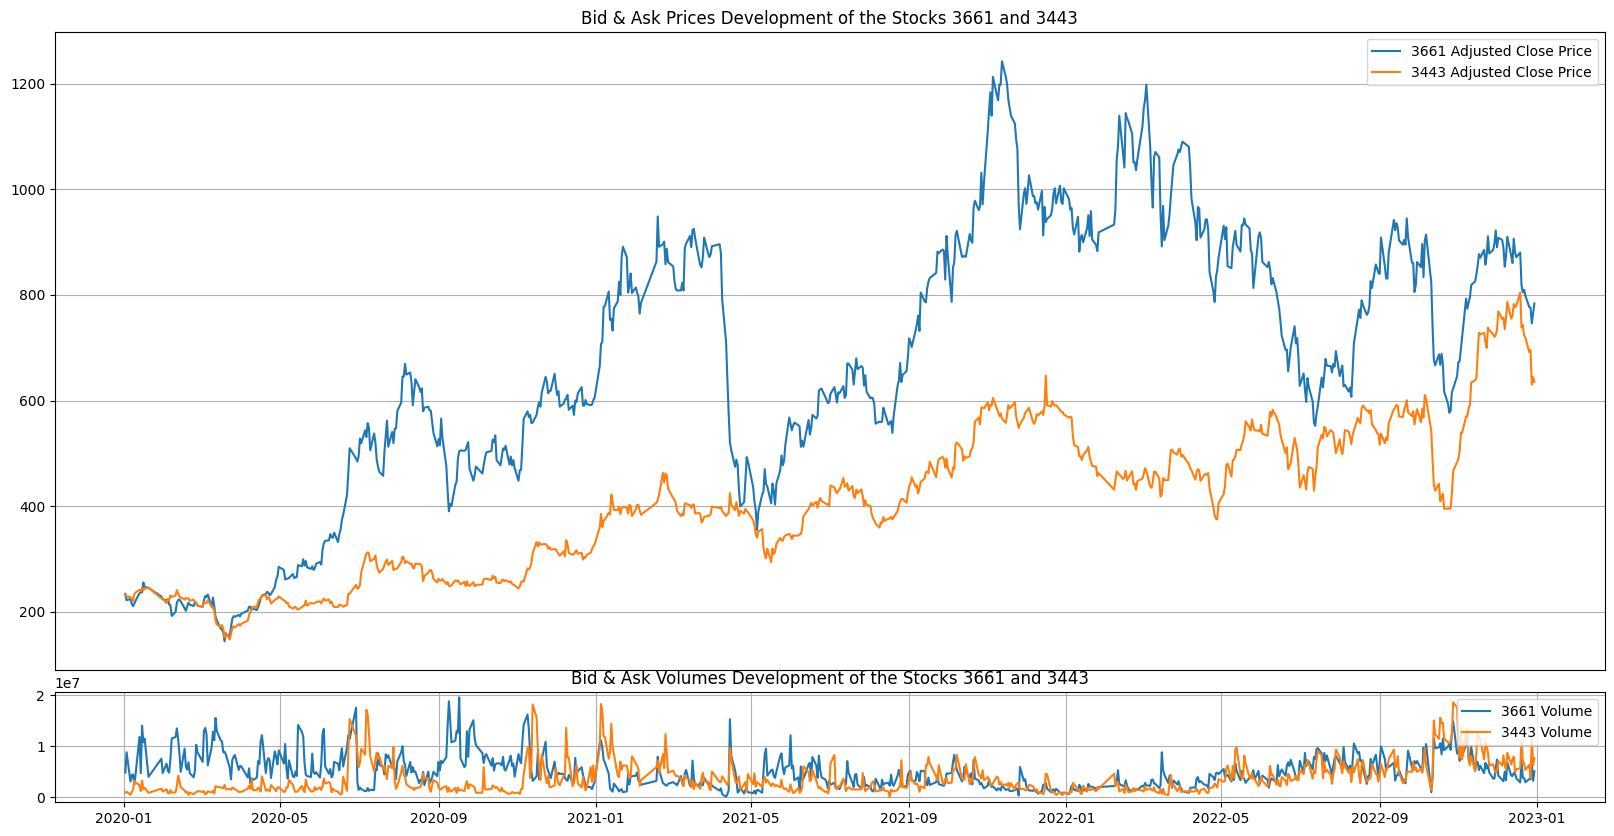

In [72]:
# Specify variable used for Plotting
market_data_segmented = market_data['2020-01-01':'2022-12-31']

# Defining Plots
def bid_ask_price_plot(stock1, stock2):
    '''
    This function creates a subplot with a specified gridsize to be able to
    effectively match it with a different subplot while still maintaining
    it's independency of being able to just show this plot.
    '''
    ax1 = plt.subplot2grid((6, 1), (0, 0), rowspan=5, colspan=1)
    plt.title('Bid & Ask Prices Development of the Stocks ' + stock1 + " and " + stock2)
    plt.grid()

    ax1.plot(market_data_segmented.index,
             market_data_segmented[stock1 + '.Price'])
    
    ax1.plot(market_data_segmented.index,
             market_data_segmented[stock2 + '.Price'])

    # We don't want to see all the timestamps
    ax1.axes.get_xaxis().set_visible(False)

    ax1.legend([stock1 + " Adjusted Close Price", stock2 + " Adjusted Close Price"], loc='upper right')

def bid_ask_volume_plot(stock1, stock2):
    '''
    This function is very similar to above's function with the exception
    of creating a smaller subplot and using different data. This function
    is meant for displaying volumes. 
    '''
    ax2 = plt.subplot2grid((6, 1), (5, 0), rowspan=1, colspan=1)
    plt.title('Bid & Ask Volumes Development of the Stocks ' + stock1 + " and " + stock2)
    plt.grid()

    ax2.plot(market_data_segmented.index,
             market_data_segmented[stock1 + '.Volume'])

    ax2.plot(market_data_segmented.index,
             market_data_segmented[stock2 + '.Volume'])

    # We don't want to see all the timestamps
    ax2.axes.get_xaxis()

    ax2.legend([stock1 + " Volume", stock2 + " Volume"], loc='upper right')

# Show Plot
plt.figure(figsize=(20, 10))
plt.show(bid_ask_price_plot("3661", "3443"), bid_ask_volume_plot("3661", "3443"))

In [73]:
# Obtain the statistical parameters for each and every pair
data_analysis = {'Pairs': [],
                 'Constant': [],
                 'Gamma': [],
                 'Alpha': [],
                 'P-Value': []}

data_zvalues = {}

for stock1 in stock_names:
    for stock2 in stock_names:
        if stock1 != stock2:
            if (stock2, stock1) in data_analysis['Pairs']:
                continue

            pairs = stock1, stock2
            constant = estimate_long_run_short_run_relationships(np.log(
                market_data_segmented[stock1+'.Price']), np.log(market_data_segmented[stock2+'.Price']))[0]
            gamma = estimate_long_run_short_run_relationships(np.log(
                market_data_segmented[stock1+'.Price']), np.log(market_data_segmented[stock2+'.Price']))[1]
            alpha = estimate_long_run_short_run_relationships(np.log(
                market_data_segmented[stock1+'.Price']), np.log(market_data_segmented[stock2+'.Price']))[2]
            pvalue = engle_granger_two_step_cointegration_test(np.log(
                market_data_segmented[stock1+'.Price']), np.log(market_data_segmented[stock2+'.Price']))[1]
            zvalue = estimate_long_run_short_run_relationships(np.log(
                market_data_segmented[stock1+'.Price']), np.log(market_data_segmented[stock2+'.Price']))[3]

            data_analysis['Pairs'].append(pairs)
            data_analysis['Constant'].append(constant)
            data_analysis['Gamma'].append(gamma)
            data_analysis['Alpha'].append(alpha)
            data_analysis['P-Value'].append(pvalue)

            data_zvalues[pairs] = zvalue
            
data_analysis = round(pd.DataFrame(data_analysis),4).set_index('Pairs')
data_analysis

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['has_const']
  warnings.warn(msg, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['has_const']
  warnings.warn(msg, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['has_const']
  warnings.warn(msg, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['has_const']
  warnings.warn(msg, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['has_const']
  warnings.warn(msg, ValueWarning)


,Constant,Gamma,Alpha,P-Value
Pairs,,,,
"(3661, 3443)",-0.2628,1.1225,-0.0073,0.1098


In [74]:
pd.DataFrame(data_zvalues)

,3661
,3443
Date,
2020-01-02,-0.394512
2020-01-03,-0.436386
2020-01-06,-0.418413
2020-01-07,-0.446448
2020-01-08,-0.445444
...,...
2022-12-26,-0.422257
2022-12-27,-0.429953


In [75]:
data_zvalues

{('3661',
  '3443'): Date
 2020-01-02   -0.394512
 2020-01-03   -0.436386
 2020-01-06   -0.418413
 2020-01-07   -0.446448
 2020-01-08   -0.445444
                 ...   
 2022-12-26   -0.422257
 2022-12-27   -0.429953
 2022-12-28   -0.358339
 2022-12-29   -0.357763
 2022-12-30   -0.317705
 Length: 734, dtype: float64}

In [76]:
tradable_pairs_analysis = data_analysis
stock_pairs = [('3661', '3443')]

# Algo

In [77]:
# Create a list of unique tradable stocks
list_stock1 = [stock[0] for stock in stock_pairs]
list_stock2 = [stock[1] for stock in stock_pairs]

for stock in list_stock2:
    list_stock1.append(stock)
    
unique_stock_list = list(set(list_stock1))

# Create a new DataFrame containing all market information for the tradable pairs
tradable_pairs_data = market_data_segmented
tradable_pairs_data

,3661.Price,3661.Volume,3443.Price,3443.Volume
Date,,,,
2020-01-02,233.482391,4828671,231.222351,919892
2020-01-03,221.856720,8812165,229.334808,1054151
2020-01-06,223.794327,3080712,227.447281,502466
2020-01-07,215.075058,4371649,225.087875,978601
2020-01-08,210.231033,4450002,220.369049,1481530
...,...,...,...,...
2022-12-26,776.899963,3578297,691.633850,6324537
2022-12-27,775.905212,3539025,695.597412,3837132
2022-12-28,746.062683,6572432,630.199341,11580932


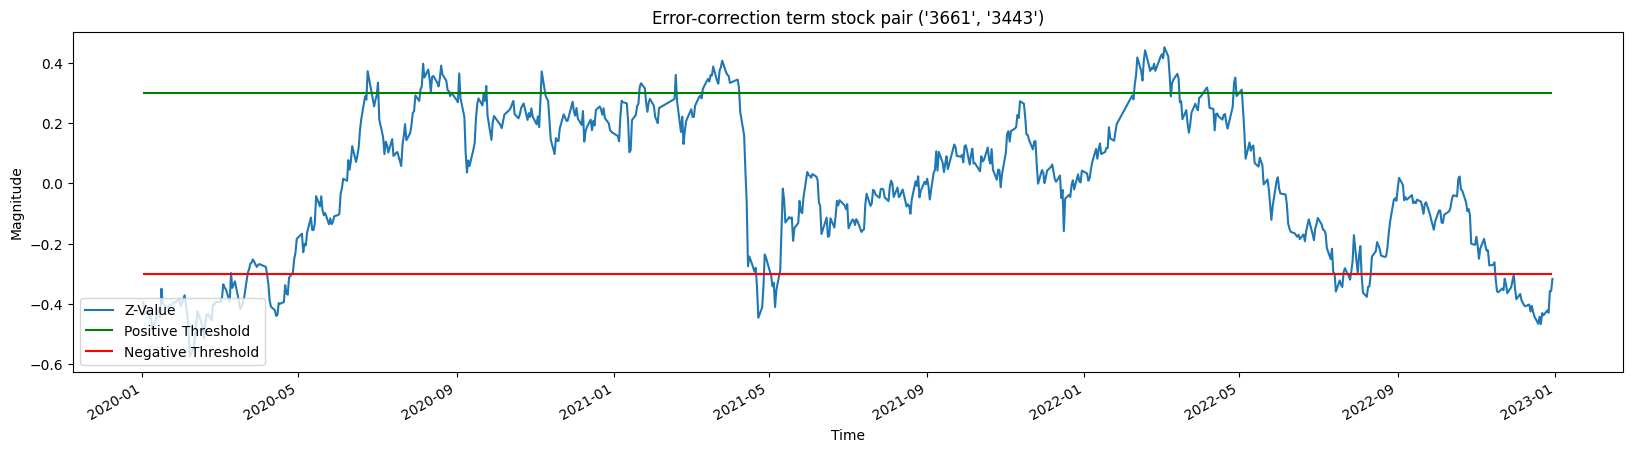

In [78]:
def Plot_Tradable_Z():
    """
    This function plots the z-values of all pairs based on
    the data_zvalues dataframe.
    """
    for pair in stock_pairs: 
        zvalue = data_zvalues[pair]
        plt.figure(figsize=(20,5))
        plt.title('Error-correction term stock pair {}'.format(pair))
        zvalue.plot()
        plt.xlabel('Time')
        plt.ylabel('Magnitude')

        xmin = zvalue.index[0]
        xmax = zvalue.index[-1]
        plt.hlines(0.3, xmin, xmax, 'g') # Note 0.005 is randomly chosen
        plt.hlines(-0.3, xmin, xmax, 'r') # Note -0.005 is randomly chosen
        
        plt.legend(['Z-Value', 'Positive Threshold', 'Negative Threshold'], loc='lower left')
        
        plt.show()
        
Plot_Tradable_Z()

In [79]:
# Create a Dataframe containing information about the error-correction term of each pair
data_error_correction_term = {'Pair': [],
                              'CountZeroCrossings': [],
                              'TradingPeriod': [],
                              'LongRunMean': [],
                              'Std': []}

for pair in stock_pairs:
    zvalue = data_zvalues[pair]
    my_array = np.array(zvalue)
    count = ((my_array[:-1] * my_array[1:]) < 0).sum()
    trading_period = 1 / count
    long_run_mean = zvalue.mean()
    std = zvalue.std()

    data_error_correction_term['Pair'].append(pair)
    data_error_correction_term['CountZeroCrossings'].append(count)
    data_error_correction_term['TradingPeriod'].append(trading_period)
    data_error_correction_term['LongRunMean'].append(round(long_run_mean, 4))
    data_error_correction_term['Std'].append(round(std, 4))

data_error_correction_term = pd.DataFrame(data_error_correction_term).set_index('Pair')

data_error_correction_term

,CountZeroCrossings,TradingPeriod,LongRunMean,Std
Pair,,,,
"(3661, 3443)",32,0.03125,-0.0,0.2436


# Threshold Analysis for All Stock Pairs

This section is for discovering what treshold would maximize profits for a given pair. We did many loops over different thresholds to find the ideal level. In the next section, the pairs with the highest profits those that are unique (prevent having a stock as 'BB' be traded twice) will be picked to determine the final profit



In [80]:
# Create a new column within the earlier defined DataFrame with Z-Values of all stock pairs
for pair in stock_pairs:
    stock1 = pair[0]
    stock2 = pair[1]
    
    tradable_pairs_data[stock1+stock2, 'Z-Value'] = data_zvalues[stock1,stock2]

tradable_pairs_data

/var/folders/8f/5fqw1kqx0xz3b9pj_q9mf9gh0000gn/T/ipykernel_24029/1146542419.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tradable_pairs_data[stock1+stock2, 'Z-Value'] = data_zvalues[stock1,stock2]


,3661.Price,3661.Volume,3443.Price,3443.Volume,"(36613443, Z-Value)"
Date,,,,,
2020-01-02,233.482391,4828671,231.222351,919892,-0.394512
2020-01-03,221.856720,8812165,229.334808,1054151,-0.436386
2020-01-06,223.794327,3080712,227.447281,502466,-0.418413
2020-01-07,215.075058,4371649,225.087875,978601,-0.446448
2020-01-08,210.231033,4450002,220.369049,1481530,-0.445444
...,...,...,...,...,...
2022-12-26,776.899963,3578297,691.633850,6324537,-0.422257
2022-12-27,775.905212,3539025,695.597412,3837132,-0.429953
2022-12-28,746.062683,6572432,630.199341,11580932,-0.358339


In [81]:
# Create a Dictionary that saves all Gamma values of each pair
gamma_dictionary = {}

for pair, value in tradable_pairs_analysis.iterrows():
    gamma_dictionary[pair]= value['Gamma']
    
gamma_dictionary

{('3661', '3443'): 1.1225}

In [82]:
# Create a Dictionary that saves all Standard Deviation values of each pair
std_dictionary = {}

for pair, value in data_error_correction_term.iterrows():
    std_dictionary[pair]= value['Std']
    
std_dictionary

{('3661', '3443'): 0.2436}

This is our Algorithm for finding the correct thresholds that are able to generate the greatest amount of profit. We find it important to not maximize the profit because what holds for historic data is not guaranteed to hold for future data. We therefore specify a limited selection of thresholds with a linspace.



In [83]:
tradable_pairs_data

,3661.Price,3661.Volume,3443.Price,3443.Volume,"(36613443, Z-Value)"
Date,,,,,
2020-01-02,233.482391,4828671,231.222351,919892,-0.394512
2020-01-03,221.856720,8812165,229.334808,1054151,-0.436386
2020-01-06,223.794327,3080712,227.447281,502466,-0.418413
2020-01-07,215.075058,4371649,225.087875,978601,-0.446448
2020-01-08,210.231033,4450002,220.369049,1481530,-0.445444
...,...,...,...,...,...
2022-12-26,776.899963,3578297,691.633850,6324537,-0.422257
2022-12-27,775.905212,3539025,695.597412,3837132,-0.429953
2022-12-28,746.062683,6572432,630.199341,11580932,-0.358339


# 改了Price

In [84]:
positions = {}
limit = 100

for pair in stock_pairs:
    stock1 = pair[0]
    stock2 = pair[1]
    
    gamma = gamma_dictionary[stock1,stock2]  # 0.9405
    
    for i in np.linspace(0.05, 1.0, 100):
        threshold = i * std_dictionary[stock1,stock2]
        
        current_position_stock1 = 0 
        current_position_stock2 = 0 
        
        column_name_stock1 = stock1 + ' Pos - Thres: ' + str(threshold)
        
        Price_Stock1 = tradable_pairs_data[stock1+'.Price'][0] # here
        Price_Stock2 = tradable_pairs_data[stock2+'.Price'][0]
        
        positions[column_name_stock1] = []
        
        for time, data_at_time in tradable_pairs_data.iterrows():
            
            Volume_Stock1 = data_at_time[stock1+'.Volume']
            Volume_Stock2 = data_at_time[stock2+'.Volume']
            
            zvalue = data_at_time[stock1+stock2,'Z-Value']

            # If the zvalues of (BB,DD) are high the spread diverges, i.e. sell BB (=stock1=y) and buy DD (=stock2=x)
            if zvalue >= threshold:
                hedge_ratio = gamma * (Price_Stock1 / Price_Stock2)
                
                if hedge_ratio >= 1:

                    max_order_stock1 = current_position_stock1 + limit
                    max_order_stock2 = max_order_stock1 / hedge_ratio

                    trade = np.floor(min((Volume_Stock1 / hedge_ratio), Volume_Stock2, max_order_stock1, max_order_stock2))

                    positions[column_name_stock1].append((- trade * hedge_ratio) + current_position_stock1)

                    current_position_stock1 = ((- trade * hedge_ratio) + current_position_stock1)
                
                elif hedge_ratio < 1:

                    max_order_stock1 = current_position_stock1 + limit
                    max_order_stock2 = max_order_stock1 * hedge_ratio

                    trade = np.floor(min((Volume_Stock1 * hedge_ratio), Volume_Stock2, max_order_stock1, max_order_stock2))

                    positions[column_name_stock1].append((- trade / hedge_ratio) + current_position_stock1)

                    current_position_stock1 = ((- trade / hedge_ratio) + current_position_stock1)

            elif zvalue <= -threshold:
                hedge_ratio = gamma * (Price_Stock1 / Price_Stock2)
                
                if hedge_ratio >= 1:

                    max_order_stock1 = abs(current_position_stock1 - limit)
                    max_order_stock2 = max_order_stock1 / hedge_ratio

                    trade = np.floor(min((Volume_Stock1 / hedge_ratio), Volume_Stock2, max_order_stock1, max_order_stock2))

                    positions[column_name_stock1].append((+ trade * hedge_ratio) + current_position_stock1)

                    current_position_stock1 = (+ trade * hedge_ratio) + current_position_stock1

                elif hedge_ratio < 1:
                    
                    max_order_stock1 = abs(current_position_stock1 - limit)
                    max_order_stock2 = max_order_stock1 * hedge_ratio

                    trade = np.floor(min((Volume_Stock1 * hedge_ratio), Volume_Stock2, max_order_stock1, max_order_stock2))

                    positions[column_name_stock1].append((+ trade / hedge_ratio) + current_position_stock1)

                    current_position_stock1 = (+ trade / hedge_ratio) + current_position_stock1  
                
                Price_Stock1 = data_at_time[stock1+'.Price']
                Price_Stock2 = data_at_time[stock2+'.Price']

            else:
                    positions[column_name_stock1].append(current_position_stock1)
        
        column_name_stock2 = stock2 + ' Pos - Thres: ' + str(threshold)
        
        if hedge_ratio >= 1:
            positions[column_name_stock2] = positions[column_name_stock1] / hedge_ratio * -1
        
        elif hedge_ratio < 1:
            positions[column_name_stock2] = positions[column_name_stock1] / (1 / hedge_ratio) * -1

In [85]:
# Create a seperate dataframe (to keep the original dataframe intact) with rounding
# Also insert the timestamp, as found in the tradeable_pairs_data DataFrame
positions_final = np.ceil(pd.DataFrame(positions))
positions_final['Timestamp'] = tradable_pairs_data.index
positions_final = positions_final.set_index('Timestamp')

In [86]:
# The difference between the positions
positions_diff = positions_final.diff()[1:]

# Positions_diff first rows
positions_diff

# OPTIONAL to Excel to Save the Amount of Trades
# positions_diff[(positions_diff != 0)].count().to_excel('Thresholds.xlsx')

,3661 Pos - Thres: 0.012180000000000002,3443 Pos - Thres: 0.012180000000000002,3661 Pos - Thres: 0.014517575757575759,3443 Pos - Thres: 0.014517575757575759,3661 Pos - Thres: 0.016855151515151517,3443 Pos - Thres: 0.016855151515151517,3661 Pos - Thres: 0.019192727272727274,3443 Pos - Thres: 0.019192727272727274,3661 Pos - Thres: 0.02153030303030303,3443 Pos - Thres: 0.02153030303030303,...,3661 Pos - Thres: 0.23424969696969697,3443 Pos - Thres: 0.23424969696969697,3661 Pos - Thres: 0.23658727272727273,3443 Pos - Thres: 0.23658727272727273,3661 Pos - Thres: 0.2389248484848485,3443 Pos - Thres: 0.2389248484848485,3661 Pos - Thres: 0.24126242424242425,3443 Pos - Thres: 0.24126242424242425,3661 Pos - Thres: 0.2436,3443 Pos - Thres: 0.2436
Timestamp,,,,,,,,,,,,,,,,,,,,,
2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-12-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-12-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


This method is used to value our last position by the correct market value. This to ensure that in the time between our last trade and the last timestamp does not hold any secrets (a market crash for example) that are not calculated in the PnL. One could say the profit is for example €50.000 while it is actually far lower because our positions are worth next to nothing due to a market crash.

In [87]:
positions_diff[-1:] = -positions_final[-1:]

To determine which threshold is the most profitable, we determine the PnL of each combination of pair and threshold. 

In [102]:
pnl_dataframe = pd.DataFrame()

for pair in stock_pairs:
    stock1 = pair[0]
    stock2 = pair[1]

    Stock1_Price = tradable_pairs_data[stock1+'.Price'][1:]
    Stock2_Price = tradable_pairs_data[stock2+'.Price'][1:]

    for i in np.linspace(0.05, 1.0, 100):
        threshold = i * std_dictionary[stock1, stock2]

        column_name_1 = stock1 + ' Pos - Thres: ' + str(threshold)
        column_name_2 = stock2 + ' Pos - Thres: ' + str(threshold)

        pnl_dataframe[stock1 + str(threshold)] = np.where(positions_diff[column_name_1] > 0,
                                                          positions_diff[column_name_1] * -Stock1_Price, positions_diff[column_name_1] * -Stock1_Price)
        pnl_dataframe[stock2 + str(threshold)] = np.where(positions_diff[column_name_2] > 0,
                                                          positions_diff[column_name_2] * -Stock2_Price, positions_diff[column_name_2] * -Stock2_Price)

pnl_dataframe.head()

/var/folders/8f/5fqw1kqx0xz3b9pj_q9mf9gh0000gn/T/ipykernel_24029/612662896.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pnl_dataframe[stock1 + str(threshold)] = np.where(positions_diff[column_name_1] > 0,
/var/folders/8f/5fqw1kqx0xz3b9pj_q9mf9gh0000gn/T/ipykernel_24029/612662896.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pnl_dataframe[stock2 + str(threshold)] = np.where(positions_diff[column_name_2] > 0,
/var/folders/8f/5fqw1kqx0xz3b9pj_q9mf9gh0000gn/T/ipykernel_24029/612662896.py:16: PerformanceWarning: DataFr

,36610.012180000000000002,34430.012180000000000002,36610.014517575757575759,34430.014517575757575759,36610.016855151515151517,34430.016855151515151517,36610.019192727272727274,34430.019192727272727274,36610.02153030303030303,34430.02153030303030303,...,36610.23424969696969697,34430.23424969696969697,36610.23658727272727273,34430.23658727272727273,36610.2389248484848485,34430.2389248484848485,36610.24126242424242425,34430.24126242424242425,36610.2436,34430.2436
0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
1,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
2,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
3,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
4,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0


In [103]:
# Create Columns for the pnl_threshold dataframe
pairs = []
thresholds = []

for pair in stock_pairs:
    stock1 = pair[0]
    stock2 = pair[1]

    for i in np.linspace(0.05, 1.0, 100):
        threshold = i * std_dictionary[stock1, stock2]
        pair = stock1, stock2
        pairs.append(pair)
        thresholds.append(threshold)

In [104]:
# Include columns and append PnLs
pnl_threshold = {'Pairs' : pairs,
                 'Thresholds': thresholds,
                 'PnLs' : []}

for pair in stock_pairs:
    stock1 = pair[0]
    stock2 = pair[1]
    
    for i in np.linspace(0.05, 1.0, 100):
        threshold = i * std_dictionary[stock1,stock2]
        pnl_threshold['PnLs'].append(pnl_dataframe[stock1 + str(threshold)].sum() + pnl_dataframe[stock2 + str(threshold)].sum())
        
pnl_threshold = pd.DataFrame(pnl_threshold)
pnl_threshold = pnl_threshold.set_index('Pairs')
# pnl_threshold.to_excel('Thresholds.xlsx')

In [105]:
pnl_threshold

,Thresholds,PnLs
Pairs,,
"(3661, 3443)",0.012180,63292.707718
"(3661, 3443)",0.014518,55132.148697
"(3661, 3443)",0.016855,55266.659256
"(3661, 3443)",0.019193,47570.111221
"(3661, 3443)",0.021530,48017.615799
...,...,...
"(3661, 3443)",0.234250,157381.429214
"(3661, 3443)",0.236587,157381.429214
"(3661, 3443)",0.238925,157381.429214


In [106]:
# Find Highest PnLs
highest_pnls = pnl_threshold.groupby(by='Pairs').agg({'PnLs' : max})
highest_pnls.sort_values('PnLs', ascending=False)

,PnLs
Pairs,
"(3661, 3443)",157381.429214


In [107]:
final_threshold = pnl_threshold[pnl_threshold['PnLs'] == highest_pnls['PnLs'].max()]['Thresholds'].iloc[0]
final_threshold

0.22957454545454545

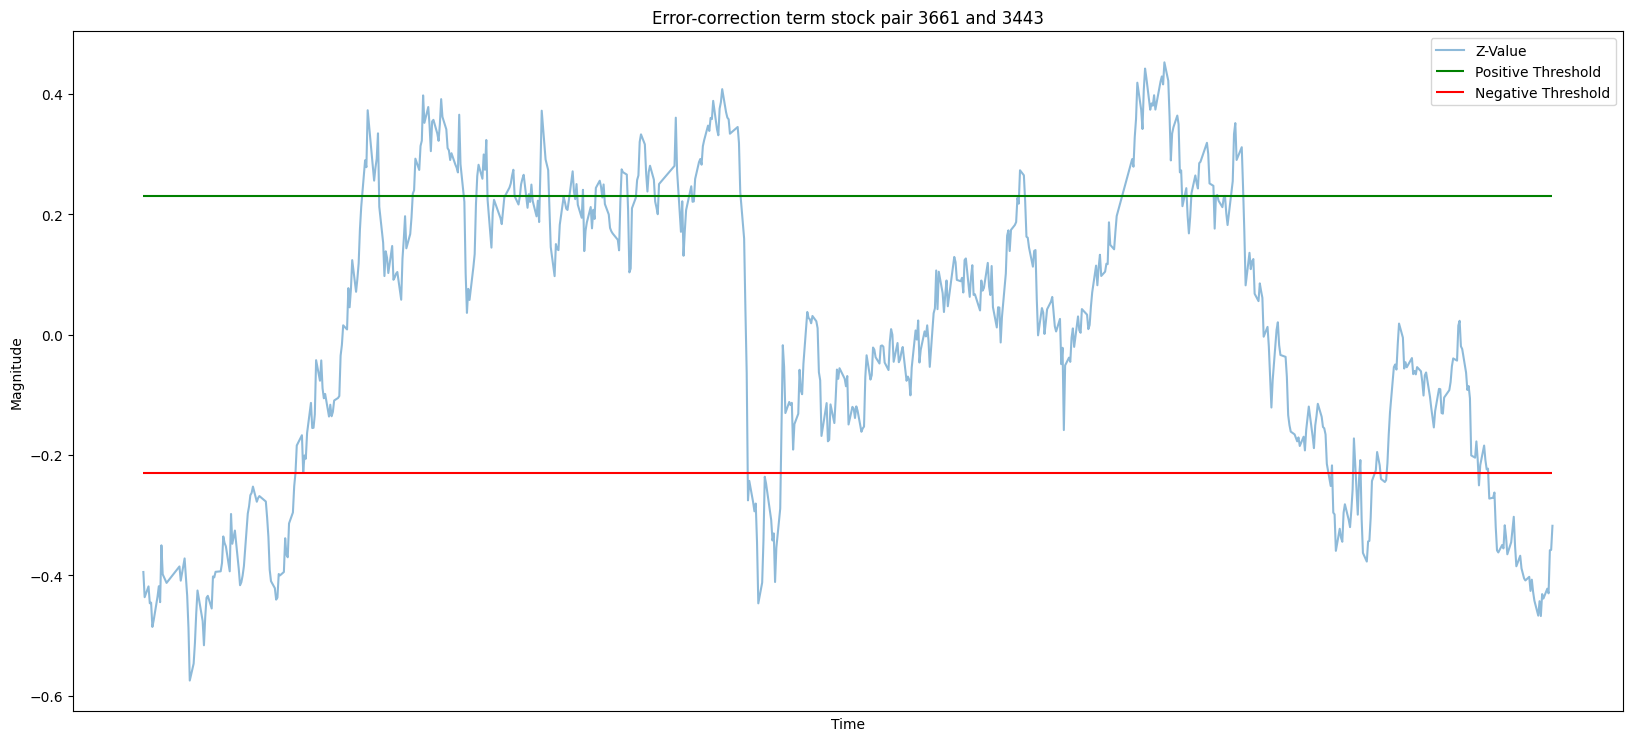

In [30]:
# Plot error-correction term (z-value) to observe what the spread looks like (see slide for comparison plot cointegrated pair)
def Plot_Thresholds(stock1, stock2):
    zvalue = tradable_pairs_data[stock1+stock2,'Z-Value']
    plt.figure(figsize=(20,10))
    plt.xticks([])
    plt.title('Error-correction term stock pair ' + stock1 + ' and ' + stock2)
    zvalue.plot(alpha=0.5)
    plt.xlabel('Time')
    plt.ylabel('Magnitude')
    xmin = zvalue.index[0]
    xmax = zvalue.index[-1]
    
    # Boundries chosen to give an approximate good fit
    plt.hlines(final_threshold, xmin, xmax, 'g')  
    plt.hlines(-final_threshold, xmin, xmax, 'r')
    
    plt.legend(['Z-Value', 'Positive Threshold', 'Negative Threshold'])
    plt.show()
        
Plot_Thresholds('3661','3443')

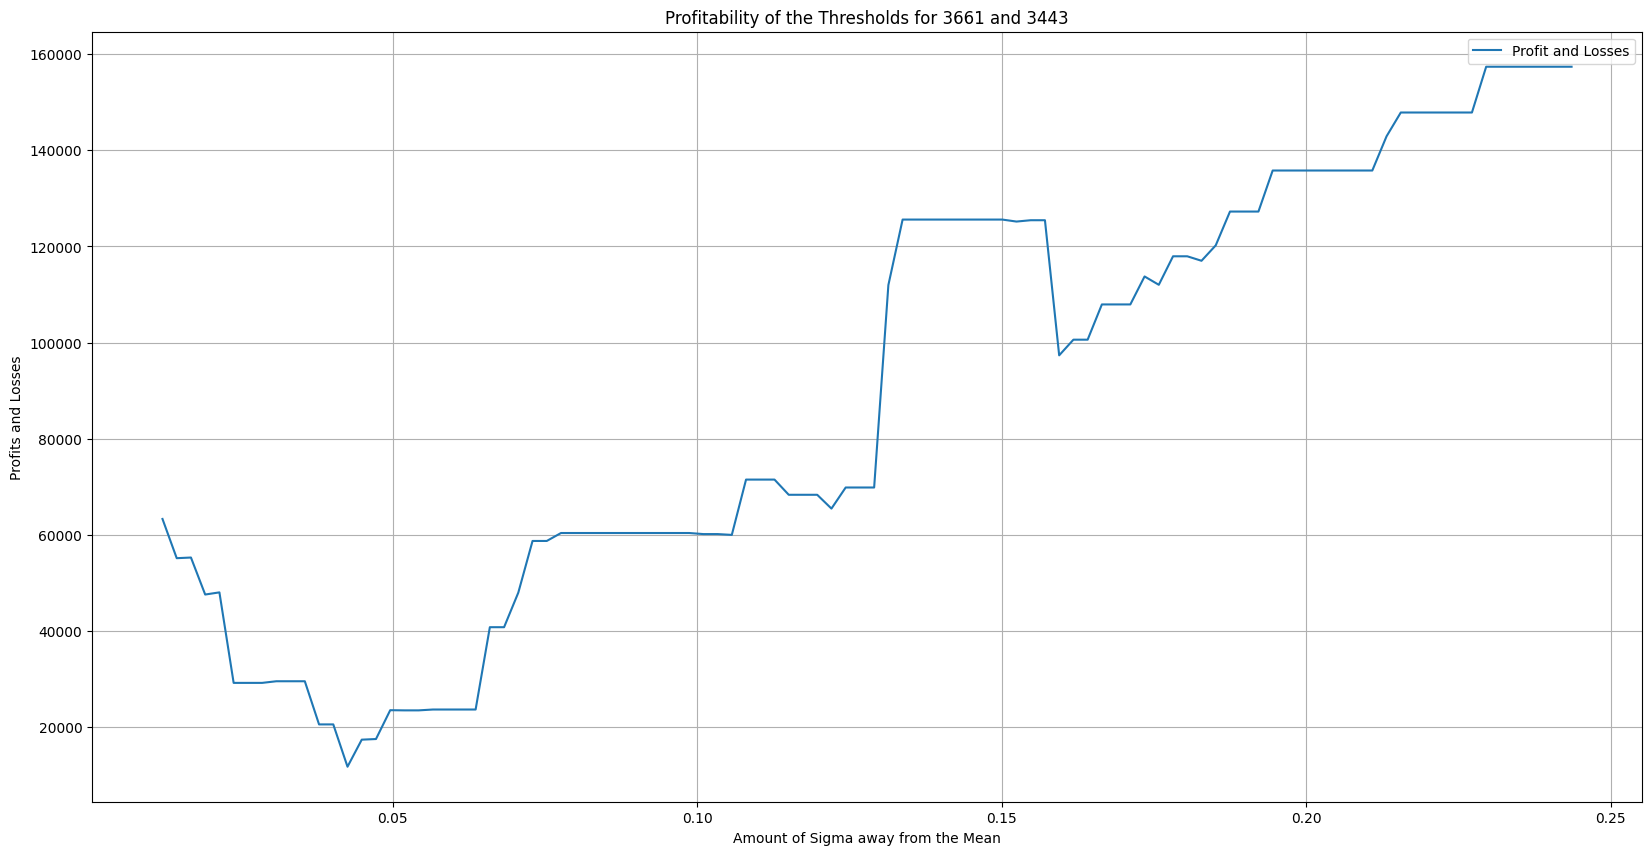

In [31]:
# Create a Plot that displays the Profitability of the Thresholds

def profitability_of_the_thresholds(stock1, stock2):
    pnl_threshold[(pnl_threshold.index == (stock1, stock2))].plot(x='Thresholds', y='PnLs', figsize=(20,10))
    plt.title('Profitability of the Thresholds for ' + stock1 + ' and ' + stock2)
    plt.xlabel('Amount of Sigma away from the Mean')
    plt.ylabel('Profits and Losses')
    plt.legend(['Profit and Losses'])
    plt.grid()

profitability_of_the_thresholds('3661','3443')

Making use of the previous analysis to determine which pairs should be traded. Based on that the algorithm, with slight modifications, is ran again to calculate the final profits.

In [32]:
# Determine the treshold, manually chosen based on pnl_threshold and ensuring no overlap.
threshold_dictionary = {('3661', '3443'): final_threshold}
threshold_dictionary

{('3661', '3443'): 0.22957454545454545}

In [33]:
# Selection of the final pairs for this trading strategy
stock_pairs_final = [('3661', '3443')]
stock_pairs_final

[('3661', '3443')]

# Testing Period

This algorithm is a slight modification as the previous one used. In this algorithm we incorporate the chosen pairs, with the corresponding tresholds, to determine the most optimal positions.

In [108]:
test_data = market_data['2023-01-01':'2023-11-30']
test_data

,3661.Price,3661.Volume,3443.Price,3443.Volume
Date,,,,
2023-01-03,850.511475,6331394,677.761536,6376960
2023-01-04,874.385498,6129339,678.752441,6241348
2023-01-05,852.500977,6167655,644.071655,8343551
2023-01-06,832.605957,4447216,644.071655,9714405
2023-01-09,849.516724,5248208,680.734192,8906941
...,...,...,...,...
2023-11-23,3125.000000,2172393,1695.000000,4337147
2023-11-24,3050.000000,1721760,1655.000000,3152871
2023-11-27,2950.000000,2088695,1610.000000,2976664


In [109]:
# Obtain the statistical parameters for each and every pair
data_analysis = {'Pairs': [],
                 'Constant': [],
                 'Gamma': [],
                 'Alpha': [],
                 'P-Value': []}

data_zvalues = {}

for stock1 in stock_names:
    for stock2 in stock_names:
        if stock1 != stock2:
            if (stock2, stock1) in data_analysis['Pairs']:
                continue

            pairs = stock1, stock2
            constant = estimate_long_run_short_run_relationships(np.log(
                test_data[stock1+'.Price']), np.log(test_data[stock2+'.Price']))[0]
            gamma = estimate_long_run_short_run_relationships(np.log(
                test_data[stock1+'.Price']), np.log(test_data[stock2+'.Price']))[1]
            alpha = estimate_long_run_short_run_relationships(np.log(
                test_data[stock1+'.Price']), np.log(test_data[stock2+'.Price']))[2]
            pvalue = engle_granger_two_step_cointegration_test(np.log(
                test_data[stock1+'.Price']), np.log(test_data[stock2+'.Price']))[1]
            zvalue = estimate_long_run_short_run_relationships(np.log(
                test_data[stock1+'.Price']), np.log(test_data[stock2+'.Price']))[3]

            data_analysis['Pairs'].append(pairs)
            data_analysis['Constant'].append(constant)
            data_analysis['Gamma'].append(gamma)
            data_analysis['Alpha'].append(alpha)
            data_analysis['P-Value'].append(pvalue)

            data_zvalues[pairs] = zvalue
            
data_analysis = round(pd.DataFrame(data_analysis),4).set_index('Pairs')
data_analysis

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['has_const']
  warnings.warn(msg, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['has_const']
  warnings.warn(msg, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['has_const']
  warnings.warn(msg, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['has_const']
  warnings.warn(msg, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['has_const']
  warnings.warn(msg, ValueWarning)


,Constant,Gamma,Alpha,P-Value
Pairs,,,,
"(3661, 3443)",-2.3799,1.3711,-0.006,0.5487


In [112]:
# Create a new column within the earlier defined DataFrame with Z-Values of all stock pairs
for pair in stock_pairs:
    stock1 = pair[0]
    stock2 = pair[1]
    
    tradable_pairs_data[stock1+stock2, 'Z-Value'] = data_zvalues[stock1,stock2]

tradable_pairs_data

/var/folders/8f/5fqw1kqx0xz3b9pj_q9mf9gh0000gn/T/ipykernel_24029/1146542419.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tradable_pairs_data[stock1+stock2, 'Z-Value'] = data_zvalues[stock1,stock2]


,3661.Price,3661.Volume,3443.Price,3443.Volume,"(36613443, Z-Value)"
Date,,,,,
2023-01-03,850.511475,6331394,677.761536,6376960,0.187694
2023-01-04,874.385498,6129339,678.752441,6241348,0.213375
2023-01-05,852.500977,6167655,644.071655,8343551,0.259938
2023-01-06,832.605957,4447216,644.071655,9714405,0.236324
2023-01-09,849.516724,5248208,680.734192,8906941,0.180524
...,...,...,...,...,...
2023-11-23,3125.000000,2172393,1695.000000,4337147,0.232220
2023-11-24,3050.000000,1721760,1655.000000,3152871,0.240672
2023-11-27,2950.000000,2088695,1610.000000,2976664,0.245133


In [113]:
tradable_pairs_analysis = data_analysis
stock_pairs = [('3661', '3443')]

In [114]:
# Create a list of unique tradable stocks
list_stock1 = [stock[0] for stock in stock_pairs]
list_stock2 = [stock[1] for stock in stock_pairs]

for stock in list_stock2:
    list_stock1.append(stock)
    
unique_stock_list = list(set(list_stock1))

# Create a new DataFrame containing all market information for the tradable pairs
tradable_pairs_data = test_data
tradable_pairs_data

,3661.Price,3661.Volume,3443.Price,3443.Volume,"(36613443, Z-Value)"
Date,,,,,
2023-01-03,850.511475,6331394,677.761536,6376960,0.187694
2023-01-04,874.385498,6129339,678.752441,6241348,0.213375
2023-01-05,852.500977,6167655,644.071655,8343551,0.259938
2023-01-06,832.605957,4447216,644.071655,9714405,0.236324
2023-01-09,849.516724,5248208,680.734192,8906941,0.180524
...,...,...,...,...,...
2023-11-23,3125.000000,2172393,1695.000000,4337147,0.232220
2023-11-24,3050.000000,1721760,1655.000000,3152871,0.240672
2023-11-27,2950.000000,2088695,1610.000000,2976664,0.245133


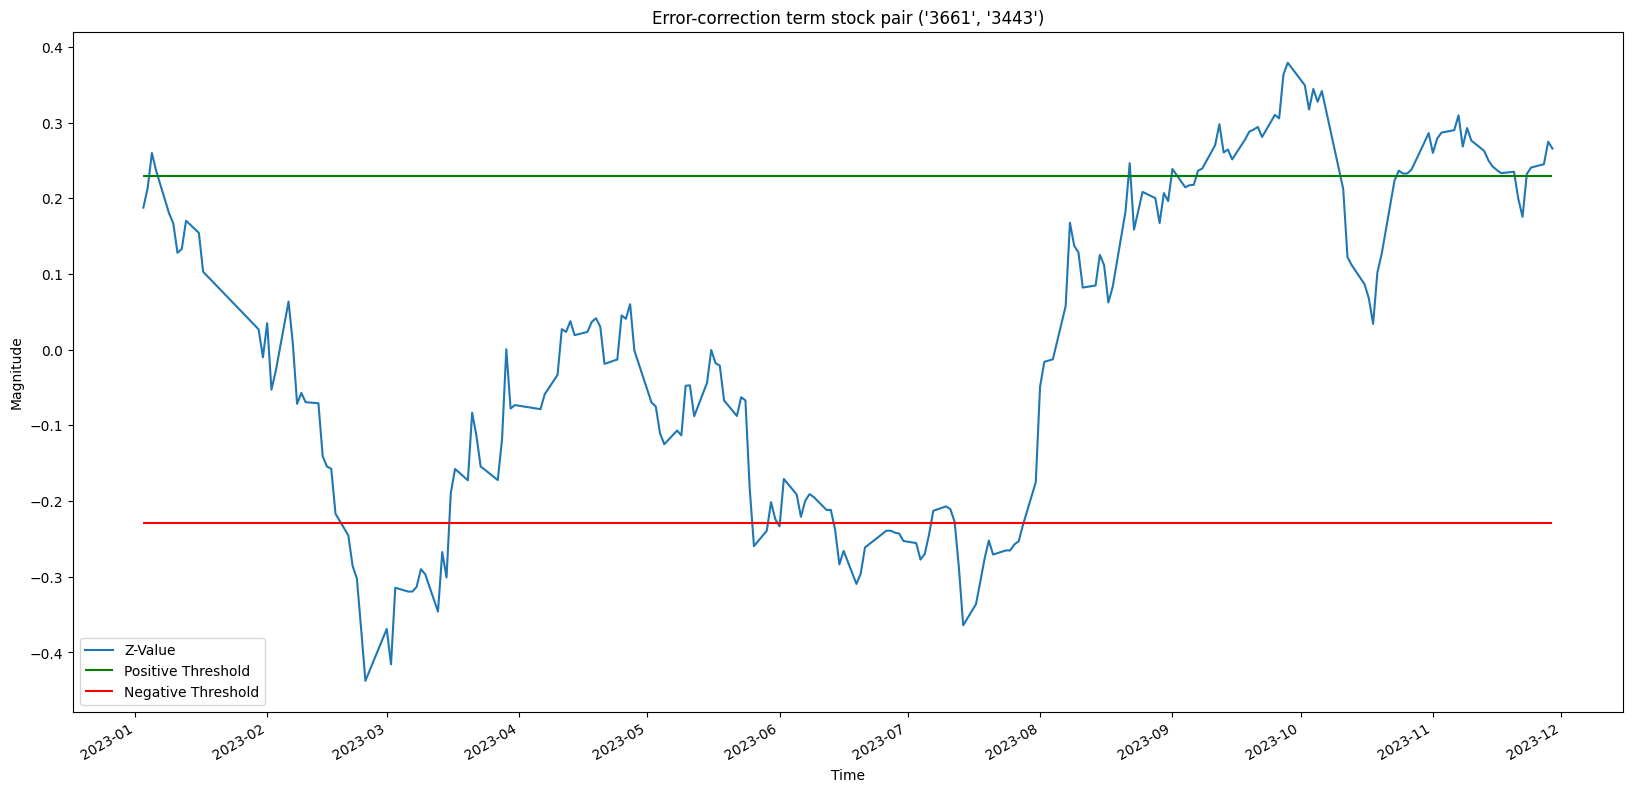

In [118]:
def Plot_Tradable_Z():
    """
    This function plots the z-values of all pairs based on
    the data_zvalues dataframe.
    """
    for pair in stock_pairs: 
        zvalue = data_zvalues[pair]
        plt.figure(figsize=(20,10))
        plt.title('Error-correction term stock pair {}'.format(pair))
        zvalue.plot()
        plt.xlabel('Time')
        plt.ylabel('Magnitude')

        xmin = zvalue.index[0]
        xmax = zvalue.index[-1]
        plt.hlines(final_threshold, xmin, xmax, 'g') # Note 0.005 is randomly chosen
        plt.hlines(-final_threshold, xmin, xmax, 'r') # Note -0.005 is randomly chosen
        
        plt.legend(['Z-Value', 'Positive Threshold', 'Negative Threshold'], loc='lower left')
        
        plt.show()
        
Plot_Tradable_Z()

In [119]:
# Create a Dataframe containing information about the error-correction term of each pair
data_error_correction_term = {'Pair': [],
                              'CountZeroCrossings': [],
                              'TradingPeriod': [],
                              'LongRunMean': [],
                              'Std': []}

for pair in stock_pairs:
    zvalue = data_zvalues[pair]
    my_array = np.array(zvalue)
    count = ((my_array[:-1] * my_array[1:]) < 0).sum()
    trading_period = 1 / count
    long_run_mean = zvalue.mean()
    std = zvalue.std()

    data_error_correction_term['Pair'].append(pair)
    data_error_correction_term['CountZeroCrossings'].append(count)
    data_error_correction_term['TradingPeriod'].append(trading_period)
    data_error_correction_term['LongRunMean'].append(round(long_run_mean, 4))
    data_error_correction_term['Std'].append(round(std, 4))

data_error_correction_term = pd.DataFrame(data_error_correction_term).set_index('Pair')

data_error_correction_term

,CountZeroCrossings,TradingPeriod,LongRunMean,Std
Pair,,,,
"(3661, 3443)",12,0.083333,0.0,0.2141


In [120]:
# Create a new column within the earlier defined DataFrame with Z-Values of all stock pairs
for pair in stock_pairs:
    stock1 = pair[0]
    stock2 = pair[1]
    
    tradable_pairs_data[stock1+stock2, 'Z-Value'] = data_zvalues[stock1,stock2]

tradable_pairs_data

/var/folders/8f/5fqw1kqx0xz3b9pj_q9mf9gh0000gn/T/ipykernel_24029/1146542419.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tradable_pairs_data[stock1+stock2, 'Z-Value'] = data_zvalues[stock1,stock2]


,3661.Price,3661.Volume,3443.Price,3443.Volume,"(36613443, Z-Value)"
Date,,,,,
2023-01-03,850.511475,6331394,677.761536,6376960,0.187694
2023-01-04,874.385498,6129339,678.752441,6241348,0.213375
2023-01-05,852.500977,6167655,644.071655,8343551,0.259938
2023-01-06,832.605957,4447216,644.071655,9714405,0.236324
2023-01-09,849.516724,5248208,680.734192,8906941,0.180524
...,...,...,...,...,...
2023-11-23,3125.000000,2172393,1695.000000,4337147,0.232220
2023-11-24,3050.000000,1721760,1655.000000,3152871,0.240672
2023-11-27,2950.000000,2088695,1610.000000,2976664,0.245133


In [121]:
# Create a Dictionary that saves all Gamma values of each pair
gamma_dictionary = {}

for pair, value in tradable_pairs_analysis.iterrows():
    gamma_dictionary[pair]= value['Gamma']
    
gamma_dictionary

{('3661', '3443'): 1.3711}

In [122]:
# Create a Dictionary that saves all Standard Deviation values of each pair
std_dictionary = {}

for pair, value in data_error_correction_term.iterrows():
    std_dictionary[pair]= value['Std']
    
std_dictionary

{('3661', '3443'): 0.2141}

In [123]:
positions_strategy_1 = {}
limit = 100

for pair in stock_pairs_final:
    stock1 = pair[0]
    stock2 = pair[1]
    
    gamma = gamma_dictionary[stock1,stock2]
    
    threshold = threshold_dictionary[stock1,stock2]
        
    current_position_stock1 = 0 
    current_position_stock2 = 0 
        
    positions_strategy_1[stock1] = []

    for time, data_at_time in tradable_pairs_data.iterrows():

        Price_Stock1 = data_at_time[stock1+'.Price']
        Price_Stock2 = data_at_time[stock2+'.Price']

        Volume_Stock1 = data_at_time[stock1+'.Volume']
        Volume_Stock2 = data_at_time[stock2+'.Volume']

        zvalue = data_at_time[stock1+stock2,'Z-Value']

        if zvalue >= threshold:
            hedge_ratio = gamma * (Price_Stock1 / Price_Stock2)
                
            if hedge_ratio >= 1:

                max_order_stock1 = current_position_stock1 + limit
                max_order_stock2 = max_order_stock1 / hedge_ratio

                trade = np.floor(min((Volume_Stock1 / hedge_ratio), Volume_Stock2, max_order_stock1, max_order_stock2))

                positions_strategy_1[stock1].append((- trade * hedge_ratio) + current_position_stock1)

                current_position_stock1 = ((- trade * hedge_ratio) + current_position_stock1)
                
            elif hedge_ratio < 1:

                max_order_stock1 = current_position_stock1 + limit
                max_order_stock2 = max_order_stock1 * hedge_ratio

                trade = np.floor(min((Volume_Stock1 * hedge_ratio), Volume_Stock2, max_order_stock1, max_order_stock2))

                positions_strategy_1[stock1].append((- trade / hedge_ratio) + current_position_stock1)

                current_position_stock1 = ((- trade / hedge_ratio) + current_position_stock1)

        elif zvalue <= -threshold:
            hedge_ratio = gamma * (Price_Stock1 / Price_Stock2)
                
            if hedge_ratio >= 1:

                max_order_stock1 = abs(current_position_stock1 - limit)
                max_order_stock2 = max_order_stock1 / hedge_ratio

                trade = np.floor(min((Volume_Stock1 / hedge_ratio), Volume_Stock2, max_order_stock1, max_order_stock2))

                positions_strategy_1[stock1].append((+ trade * hedge_ratio) + current_position_stock1)

                current_position_stock1 = (+ trade * hedge_ratio) + current_position_stock1

            elif hedge_ratio < 1:
                    
                max_order_stock1 = abs(current_position_stock1 - limit)
                max_order_stock2 = max_order_stock1 * hedge_ratio

                trade = np.floor(min((Volume_Stock1 * hedge_ratio), Volume_Stock2, max_order_stock1, max_order_stock2))

                positions_strategy_1[stock1].append((+ trade / hedge_ratio) + current_position_stock1)

                current_position_stock1 = (+ trade / hedge_ratio) + current_position_stock1   

        else:

                positions_strategy_1[stock1].append(current_position_stock1)
        
    if hedge_ratio >= 1:
        positions_strategy_1[stock2] = positions_strategy_1[stock1] / hedge_ratio * -1
        
    elif hedge_ratio < 1:
        positions_strategy_1[stock2] = positions_strategy_1[stock1] / (1 / hedge_ratio) * -1

In [124]:
# Set Ceiling (to prevent positions with not enough volume available) as well as define the timestamp
positions_strategy_1 = np.ceil(pd.DataFrame(positions_strategy_1))
positions_strategy_1['Timestamp'] = tradable_pairs_data.index
positions_strategy_1 = positions_strategy_1.set_index('Timestamp')

In [125]:
# The difference between the positions
positions_diff_strategy_1 = positions_strategy_1.diff()[1:]
positions_diff_strategy_1
# # Positions_diff first rows
# positions_diff_strategy_1.head()

,3661,3443
Timestamp,,
2023-01-04,0.0,0.0
2023-01-05,-99.0,39.0
2023-01-06,0.0,0.0
2023-01-09,0.0,0.0
2023-01-10,0.0,0.0
...,...,...
2023-11-23,0.0,0.0
2023-11-24,0.0,0.0
2023-11-27,0.0,0.0


In [126]:
#Used as mentioned earlier.
positions_diff_strategy_1[-1:] = -positions_strategy_1[-1:]

In [127]:
positions_strategy_1

,3661,3443
Timestamp,,
2023-01-03,0.0,-0.0
2023-01-04,0.0,-0.0
2023-01-05,-99.0,39.0
2023-01-06,-99.0,39.0
2023-01-09,-99.0,39.0
...,...,...
2023-11-23,-97.0,38.0
2023-11-24,-97.0,38.0
2023-11-27,-97.0,38.0


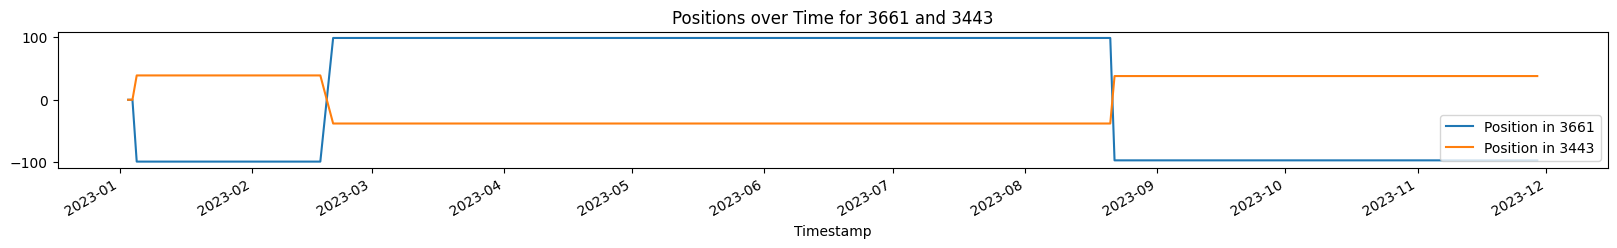

In [134]:
# Show Positions over Time
for pairs in stock_pairs_final:
    stock1 = pairs[0]
    stock2 = pairs[1]
    
    plt.figure(figsize=(20,2))
    
    positions_strategy_1[stock1].plot()
    positions_strategy_1[stock2].plot()
    
    plt.title('Positions over Time for ' + stock1 + ' and ' + stock2)
    plt.legend(["Position in " + stock1,"Position in " + stock2], loc='lower right')
    
    plt.show()

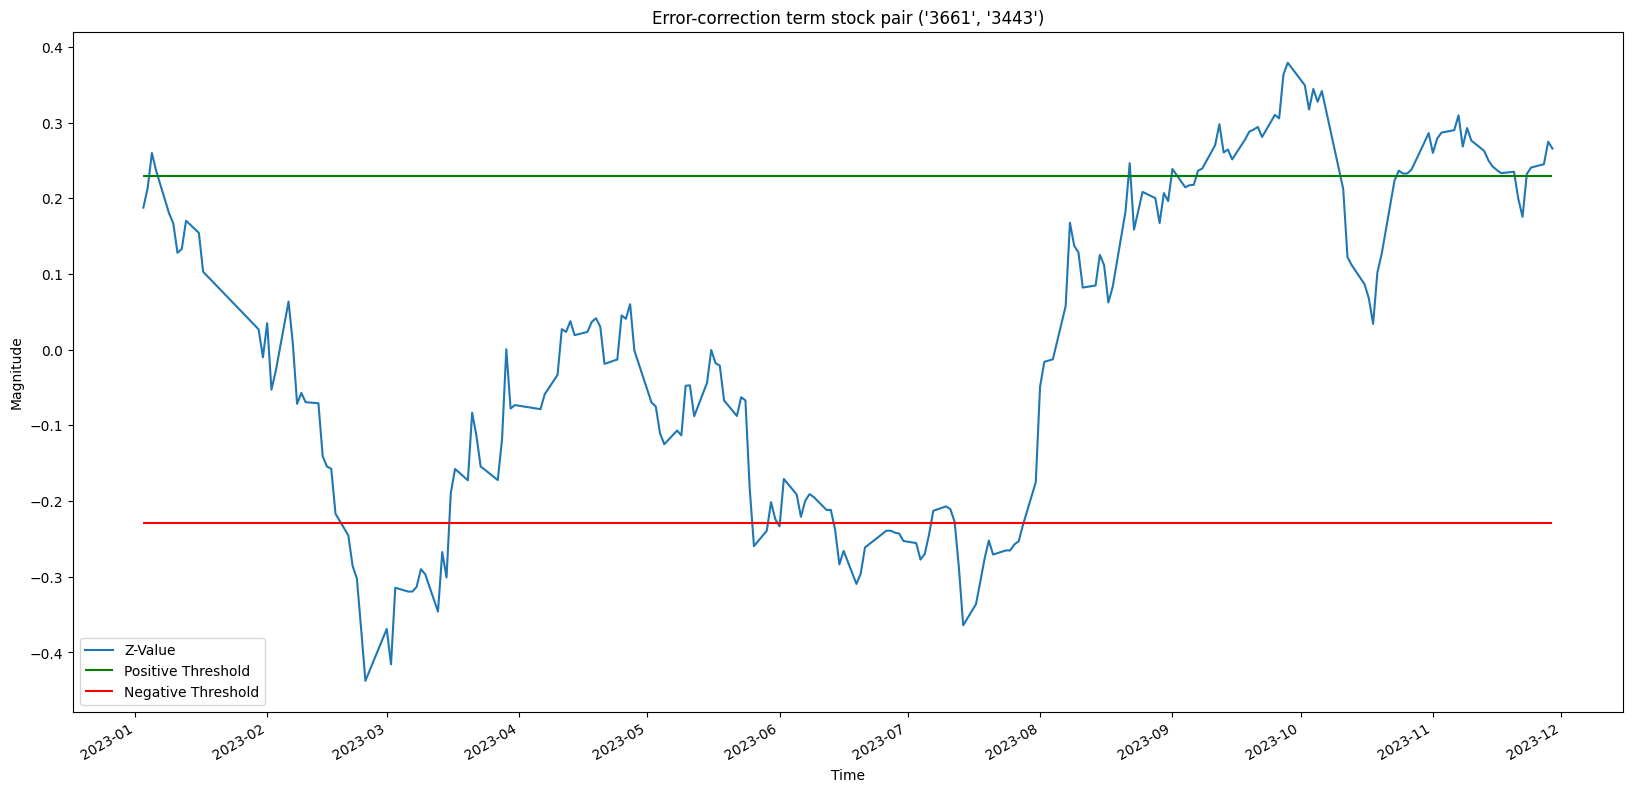

In [129]:
Plot_Tradable_Z()

Re-run the PnL forloop to determine the profits. This could also be manually calculated with pnl_threshold values.

In [130]:
pnl_dataframe_strategy_1

,3661,3443,PnL,Cum PnL,36613443 PnL,36613443 Cum PnL
Timestamp,,,,,,
2023-01-04,-0.00000,-0.000000,0.000000,0.000000,-0.000000,-0.000000
2023-01-05,84397.59668,-25118.794556,59278.802124,59278.802124,59278.802124,59278.802124
2023-01-06,-0.00000,-0.000000,0.000000,59278.802124,-0.000000,59278.802124
2023-01-09,-0.00000,-0.000000,0.000000,59278.802124,-0.000000,59278.802124
2023-01-10,-0.00000,-0.000000,0.000000,59278.802124,-0.000000,59278.802124
...,...,...,...,...,...,...
2023-11-23,-0.00000,-0.000000,0.000000,312523.701660,-0.000000,312523.701660
2023-11-24,-0.00000,-0.000000,0.000000,312523.701660,-0.000000,312523.701660
2023-11-27,-0.00000,-0.000000,0.000000,312523.701660,-0.000000,312523.701660


In [131]:
pnl_dataframe_strategy_1 = pd.DataFrame()

for pair in stock_pairs_final:
    stock1 = pair[0]
    stock2 = pair[1]
    
    Stock1_Price = tradable_pairs_data[stock1+'.Price'][1:]
    Stock2_Price = tradable_pairs_data[stock2+'.Price'][1:]

    pnl_dataframe_strategy_1[stock1] = np.where(positions_diff_strategy_1[stock1] > 0, positions_diff_strategy_1[stock1] * -Stock1_Price, positions_diff_strategy_1[stock1] * -Stock1_Price)
    pnl_dataframe_strategy_1[stock2] = np.where(positions_diff_strategy_1[stock2] > 0, positions_diff_strategy_1[stock2] * -Stock2_Price, positions_diff_strategy_1[stock2] * -Stock2_Price)

print("The total profit is: TWD$",round(pnl_dataframe_strategy_1.iloc[:-1].sum().sum()))

The total profit is: TWD$ 312524


In [132]:
pnl_dataframe_strategy_1['Timestamp'] = tradable_pairs_data.index[1:]
pnl_dataframe_strategy_1 = pnl_dataframe_strategy_1.set_index('Timestamp')

pnl_dataframe_strategy_1['PnL'] = pnl_dataframe_strategy_1.sum(axis=1)
pnl_dataframe_strategy_1['Cum PnL'] = pnl_dataframe_strategy_1['PnL'].cumsum()

for pair in stock_pairs_final:
    stock1 = pair[0]
    stock2 = pair[1]

    pnl_dataframe_strategy_1[stock1+stock2 + ' PnL'] = pnl_dataframe_strategy_1[stock1] + pnl_dataframe_strategy_1[stock2]
    pnl_dataframe_strategy_1[stock1+stock2 + ' Cum PnL'] = pnl_dataframe_strategy_1[stock1+stock2 + ' PnL'].cumsum()

pnl_dataframe_strategy_1.tail()

,3661,3443,PnL,Cum PnL,36613443 PnL,36613443 Cum PnL
Timestamp,,,,,,
2023-11-23,-0.0,-0.0,0.0,312523.70166,-0.0,312523.70166
2023-11-24,-0.0,-0.0,0.0,312523.70166,-0.0,312523.70166
2023-11-27,-0.0,-0.0,0.0,312523.70166,-0.0,312523.70166
2023-11-28,-0.0,-0.0,0.0,312523.70166,-0.0,312523.70166
2023-11-29,-295850.0,61750.0,-234100.0,78423.70166,-234100.0,78423.70166


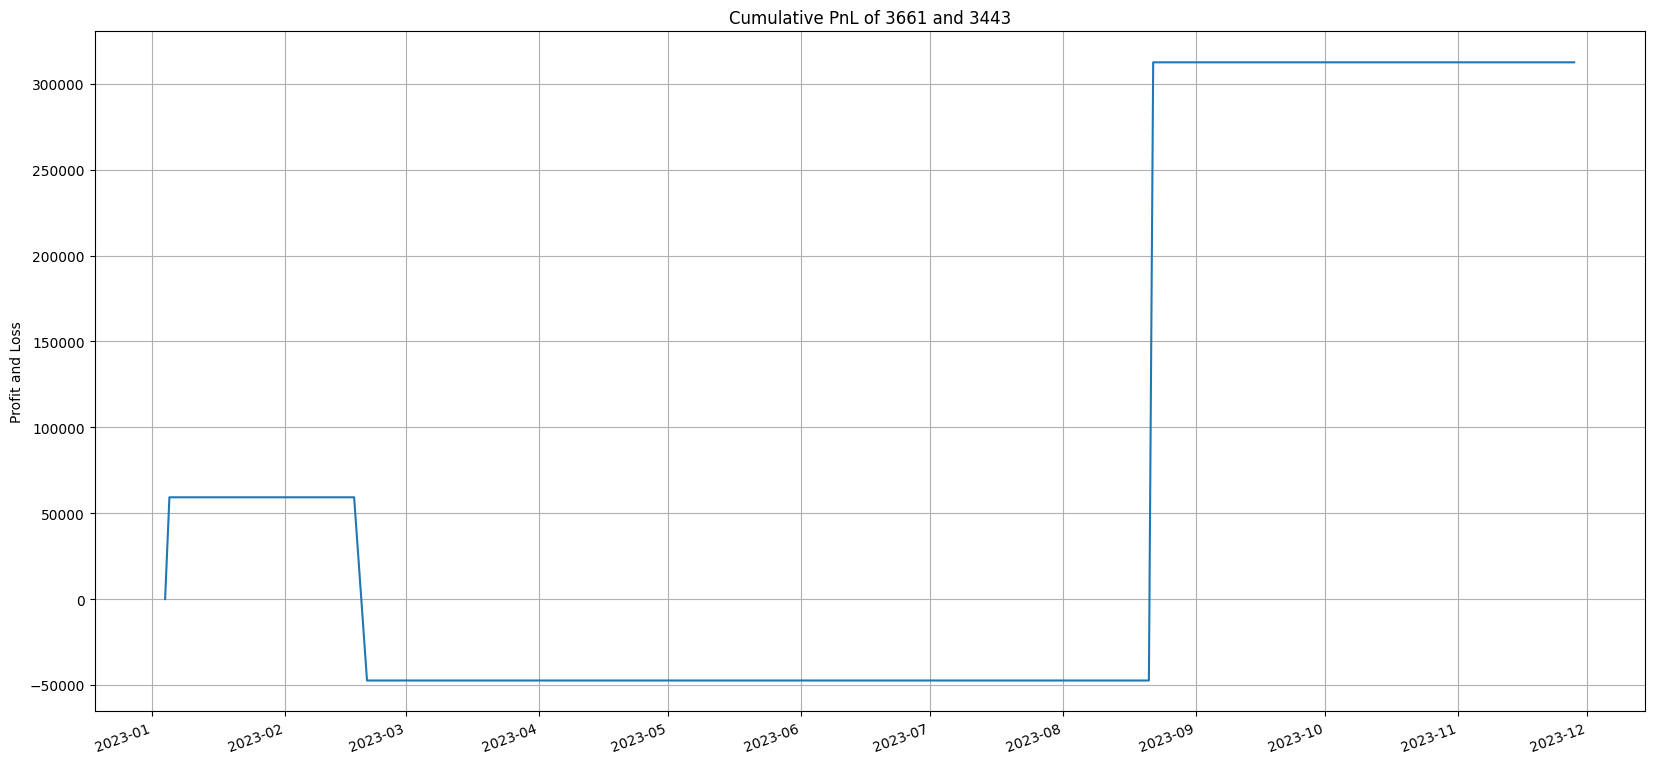

In [136]:
# All Pairs's PnL

for pair in stock_pairs_final:
    stock1 = pair[0]
    stock2 = pair[1]
    
    pnl_dataframe_strategy_1[stock1+stock2 + ' Cum PnL'].iloc[:-1].plot(figsize=(20,10))
    plt.title('Cumulative PnL of ' + stock1 + ' and ' + stock2)
    plt.ylabel('Profit and Loss')
    plt.xlabel("")
    plt.grid()
    plt.xticks(rotation=20)
    plt.show()
